In [88]:
import numpy as np
import math
import pandas as pd
import os
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import jpholiday
from sklearn.preprocessing import LabelEncoder
from ydata_profiling import ProfileReport
from matplotlib import rcParams

rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Hiragino Sans GB']

pd.options.display.max_rows = 1000
pd.options.display.max_columns = 300

%matplotlib inline

In [89]:
train = pd.read_csv('./given_files/train.csv', encoding='utf-8')
search_specified = pd.read_csv('./given_files/search_specified.csv', encoding='utf-8')
search_unspecified = pd.read_csv('./given_files/search_unspecified.csv', encoding='utf-8')
road = pd.read_csv('./given_files/road_local.csv', encoding='utf-8')

In [90]:
# day_of_week, day_of_year, holiday, tomorrow_holiday, yesterday_holidayを追加
def is_holiday(date):
    
    return (date.weekday() >= 5) or jpholiday.is_holiday(date)


def set_flags(df):
    
    df['tomorrow'] = df['date'] + pd.to_timedelta(1, 'd')
    df['day_of_week'] = df['date'].dt.weekday
    
    holidays = df['date'].apply(jpholiday.is_holiday)

    df['holiday'] = ((df['day_of_week'] >= 5) | holidays).astype(int)
    df['tomorrow_holiday'] = ((df['tomorrow'].dt.weekday >= 5) | holidays.shift(-1)).astype(int)
    
    # 連休何日目か(n_of_holidays)を追加
    mask = df['holiday'] != df['holiday'].shift(1).fillna(0)
    df['n_of_holidays'] = df.groupby(mask.cumsum()).cumcount() + 1
    df.loc[df['holiday'] == 0, 'n_of_holidays'] = 0
    
    # 連休の始まりを特定
    df['holiday_start'] = ((df['holiday'] == 1) & (df['holiday'].shift(1) == 0)).astype(int)
    # 連休の終わりを特定
    df['holiday_end'] = ((df['holiday'] == 1) & (df['holiday'].shift(-1) == 0)).astype(int)
    # 連休の中間を特定
    df['holiday_mid'] = (df['holiday'] & ~(df['holiday_start'] | df['holiday_end'])).astype(int)

    
    df = df.drop(['tomorrow'], axis=1)
    
    return df

search_unspecified['date'] = pd.to_datetime(search_unspecified['date'])

search_unspecified = set_flags(search_unspecified)

search_unspecified['day_of_year'] = search_unspecified['date'].dt.dayofyear

def expand_datetime(df):
    if 'date' in df.columns:
        df['year'] = df['date'].dt.year
        df['month'] = df['date'].dt.month
        df['day'] = df['date'].dt.day
    if 'datetime' in df.columns:
        df['year'] = df['datetime'].dt.year
        df['month'] = df['datetime'].dt.month
        df['day'] = df['datetime'].dt.day
        df['hour'] = df['datetime'].dt.hour
    return df

train['datetime'] = pd.to_datetime(train['datetime'])
train['date'] = train['datetime'].dt.date
train['date'] = pd.to_datetime(train['date'])
search_specified['datetime'] = pd.to_datetime(search_specified['datetime'])
search_unspecified['date'] = pd.to_datetime(search_unspecified['date'])
search_specified['datetime'] -= pd.to_timedelta(1, 'd')
search_unspecified['date'] -= pd.to_timedelta(1, 'd')

train = expand_datetime(train)

train_merged = train.merge(search_specified, on=['datetime', 'start_code', 'end_code'], how='left')

train_merged = train_merged.merge(search_unspecified, on=['date', 'start_code', 'end_code'], how='left')

train_merged = train_merged.merge(road, on=['start_code', 'end_code'], how='left')

In [91]:
#train_merged['section'] = train_merged['start_code'].astype(str) + '_' + train_merged['KP'].astype(str) + '_' + train_merged['end_code'].astype(str)
#
#label_encoder = LabelEncoder()
#train_merged['section'] = label_encoder.fit_transform(train_merged['section'])

train_merged['direction'] = train_merged['direction'].replace({'上り': 1, '下り': 0})

train_merged['block'] = train_merged['start_code'].astype(str) + '_' + train_merged['end_code'].astype(str)

#label_encoder = LabelEncoder()
#train_merged['block'] = label_encoder.fit_transform(train_merged['block'])

In [92]:
train_merged['is_congestion_date_count'] = train_merged.groupby(['date'])['is_congestion'].transform('sum')
train_merged['speed_date_mean'] = train_merged.groupby(['date'])['speed'].transform('mean')
train_merged['OCC_date_mean'] = train_merged.groupby(['date'])['OCC'].transform('mean')
train_merged['allCars_date_mean'] = train_merged.groupby(['date'])['allCars'].transform('mean')
train_merged['search_specified_date_mean'] = train_merged.groupby(['date'])['search_specified'].transform('mean')
train_merged['search_unspecified_date_mean'] = train_merged.groupby(['date'])['search_unspecified'].transform('mean')

date_df = train_merged[['date', 'is_congestion_date_count', 'speed_date_mean', 'OCC_date_mean', 'allCars_date_mean', 'search_specified_date_mean', 'search_unspecified_date_mean']].drop_duplicates()
date_df = date_df[(date_df['date'] >= dt.datetime(2022,1,1,0,0,0)) & (date_df['date'] <= dt.datetime(2022,12,31,23,59,59))]

date_df_202207 = date_df[(date_df['date'] >= dt.datetime(2022,7,1,0,0,0)) & (date_df['date'] <= dt.datetime(2022,7,31,23,59,59))]



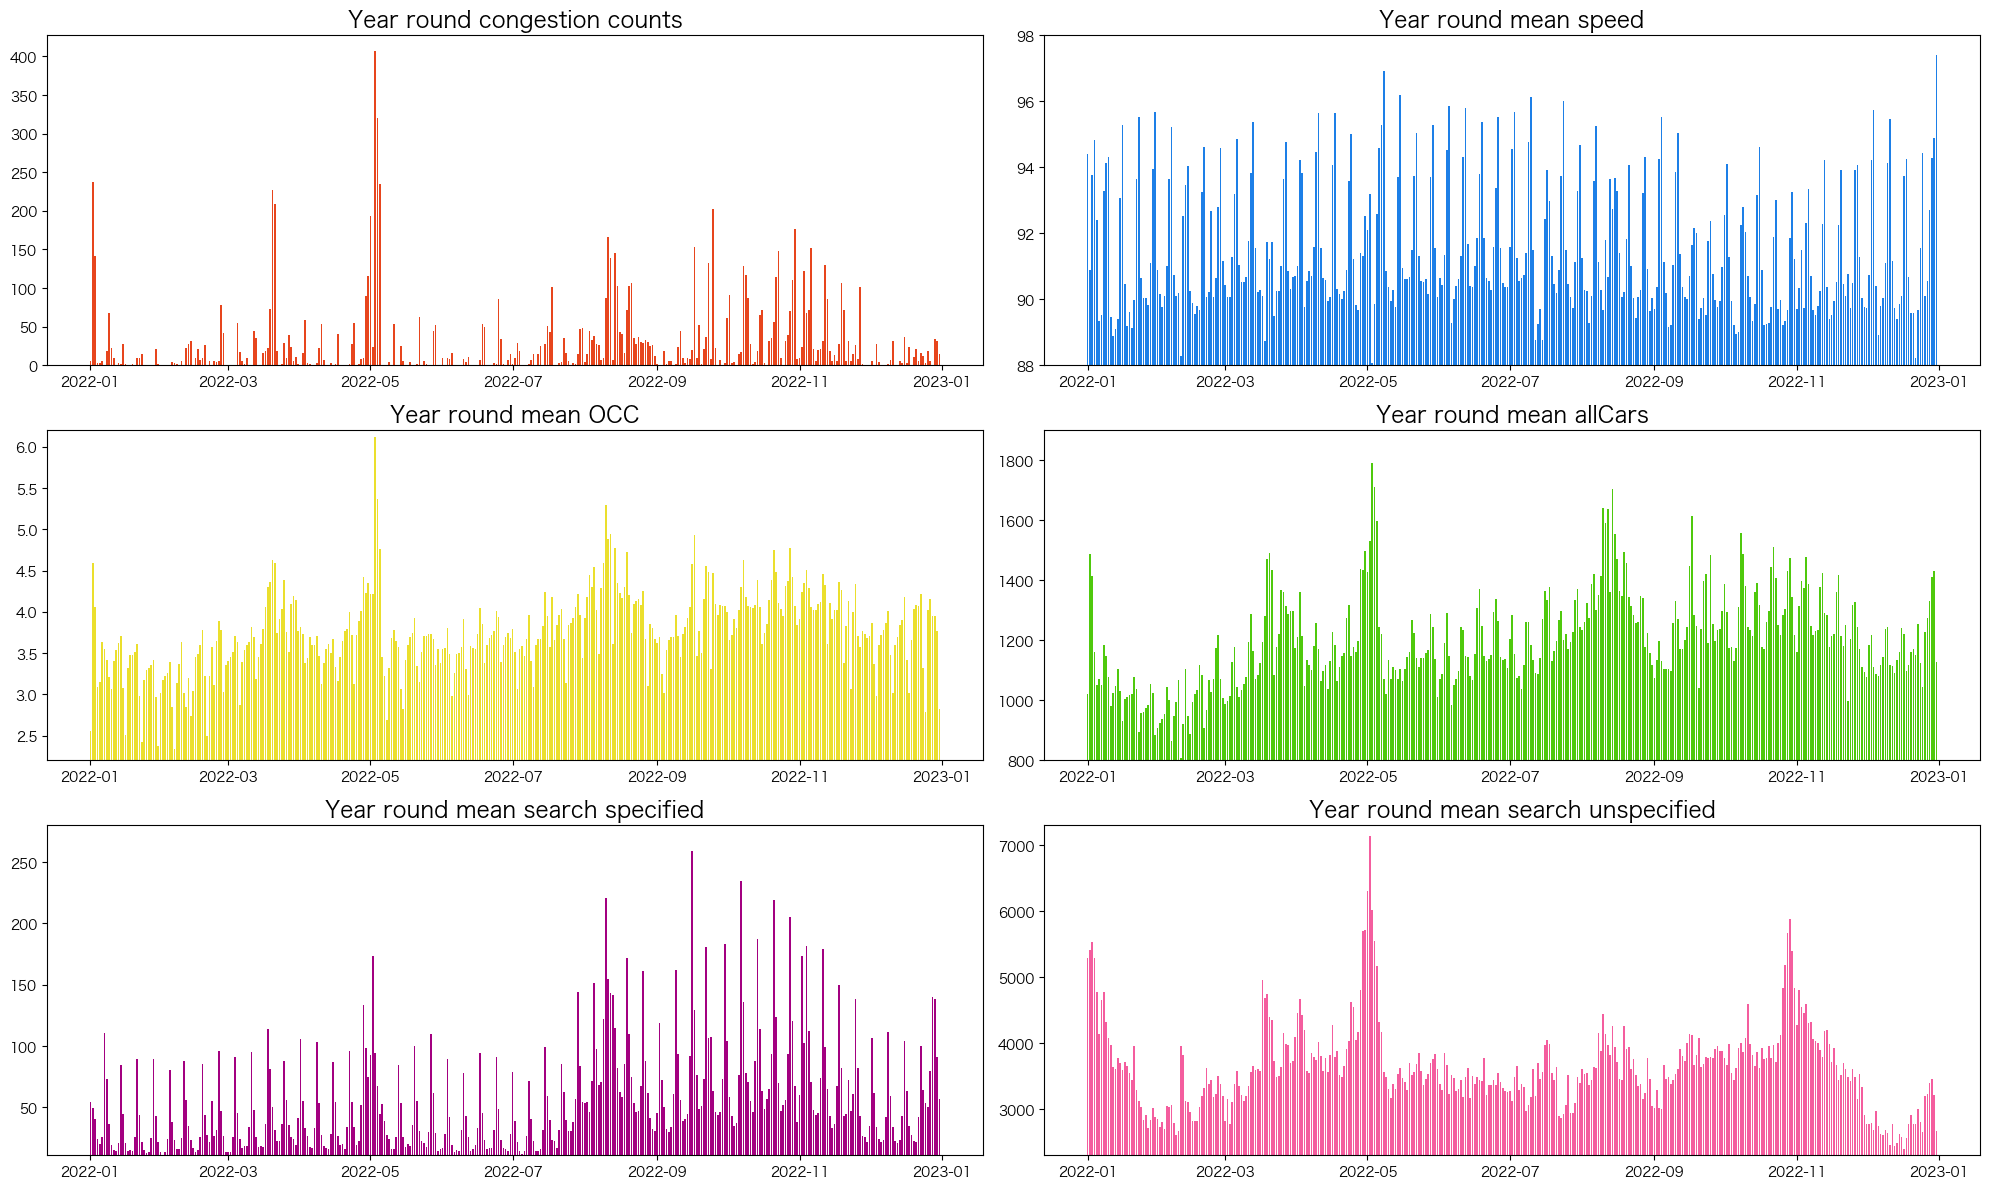

In [93]:
fig = plt.figure(figsize=(20,12), layout='tight')

ax1 = fig.add_subplot(321, title='Year round congestion counts')
ax2 = fig.add_subplot(322, title='Year round mean speed', ylim=(88,98))
ax3 = fig.add_subplot(323, title='Year round mean OCC', ylim=(2.2, 6.2))
ax4 = fig.add_subplot(324, title='Year round mean allCars', ylim=(800, 1900))
ax5 = fig.add_subplot(325, title='Year round mean search specified', ylim=(11, 280))
ax6 = fig.add_subplot(326, title='Year round mean search unspecified', ylim=(2300, 7300))

ax1.set_title('Year round congestion counts', fontsize=16)
ax2.set_title('Year round mean speed', fontsize=16)
ax3.set_title('Year round mean OCC', fontsize=16)
ax4.set_title('Year round mean allCars', fontsize=16)
ax5.set_title('Year round mean search specified', fontsize=16)
ax6.set_title('Year round mean search unspecified', fontsize=16)

ax1.bar(date_df['date'], date_df['is_congestion_date_count'], width=0.7, fc='#E7451D')
ax2.bar(date_df['date'], date_df['speed_date_mean'], width=0.7, fc='#1D7FE7')
ax3.bar(date_df['date'], date_df['OCC_date_mean'], width=0.7, fc='#EBDF2D')
ax4.bar(date_df['date'], date_df['allCars_date_mean'], width=0.7, fc='#4FC90D')
ax5.bar(date_df['date'], date_df['search_specified_date_mean'], width=0.7, fc='#A30080')
ax6.bar(date_df['date'], date_df['search_unspecified_date_mean'], width=0.7, fc='#F45D9E')

plt.savefig('./pictures/features_bar_year_round.png')

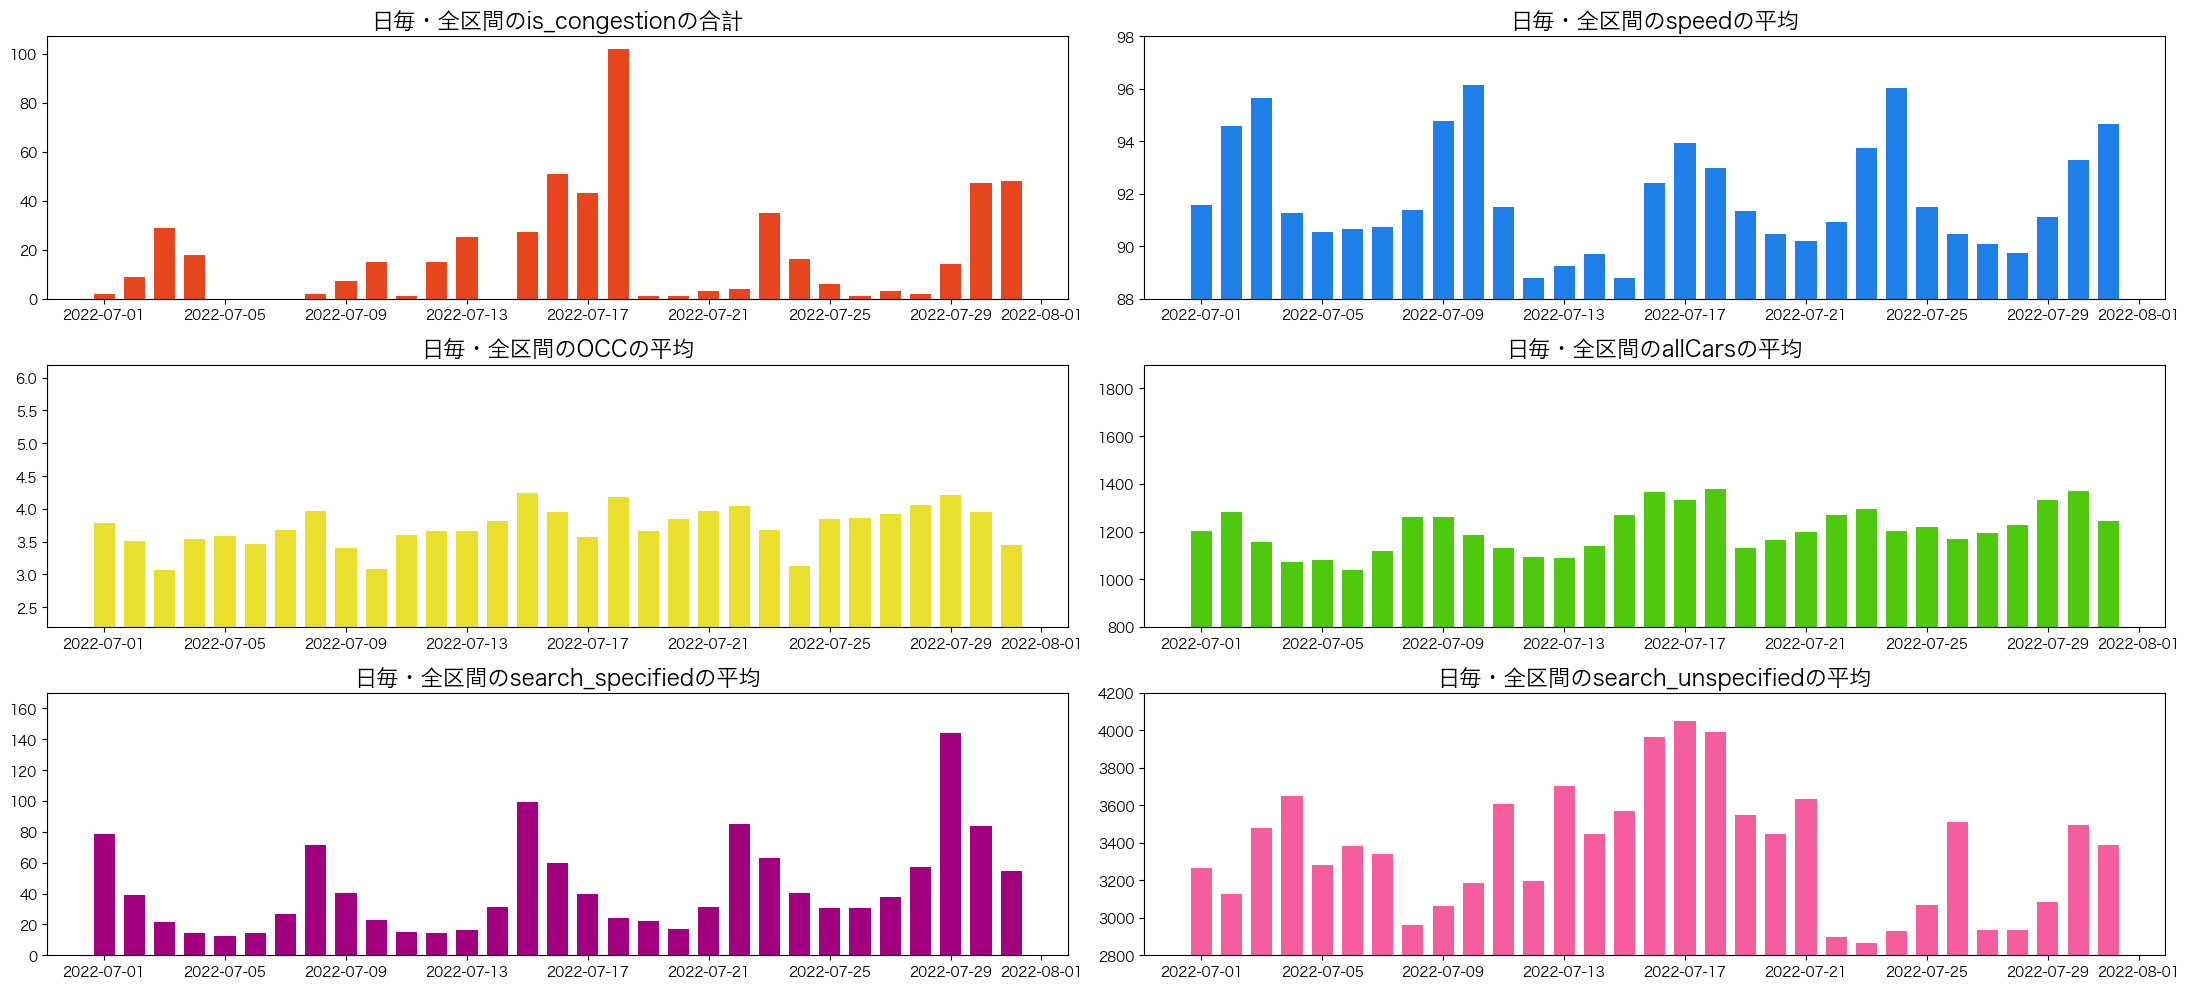

In [106]:
fig = plt.figure(figsize=(22,10), layout='tight')

ax1 = fig.add_subplot(321, title='日毎・全区間のis_congestionの合計')
ax2 = fig.add_subplot(322, title='日毎・全区間のspeedの平均', ylim=(88,98))
ax3 = fig.add_subplot(323, title='日毎・全区間のOCCの平均', ylim=(2.2, 6.2))
ax4 = fig.add_subplot(324, title='日毎・全区間のallCarsの平均', ylim=(800, 1900))
ax5 = fig.add_subplot(325, title='日毎・全区間のsearch_specifiedの平均', ylim=(0, 170))
ax6 = fig.add_subplot(326, title='日毎・全区間のsearch_unspecifiedの平均', ylim=(2800, 4200))

ax1.set_title('日毎・全区間のis_congestionの合計', fontsize=16)
ax2.set_title('日毎・全区間のspeedの平均', fontsize=16)
ax3.set_title('日毎・全区間のOCCの平均', fontsize=16)
ax4.set_title('日毎・全区間のallCarsの平均', fontsize=16)
ax5.set_title('日毎・全区間のsearch_specifiedの平均', fontsize=16)
ax6.set_title('日毎・全区間のsearch_unspecifiedの平均', fontsize=16)

ax1.bar(date_df_202207['date'], date_df_202207['is_congestion_date_count'], width=0.7, fc='#E7451D')
ax2.bar(date_df_202207['date'], date_df_202207['speed_date_mean'], width=0.7, fc='#1D7FE7')
ax3.bar(date_df_202207['date'], date_df_202207['OCC_date_mean'], width=0.7, fc='#EBDF2D')
ax4.bar(date_df_202207['date'], date_df_202207['allCars_date_mean'], width=0.7, fc='#4FC90D')
ax5.bar(date_df_202207['date'], date_df_202207['search_specified_date_mean'], width=0.7, fc='#A30080')
ax6.bar(date_df_202207['date'], date_df_202207['search_unspecified_date_mean'], width=0.7, fc='#F45D9E')

plt.savefig('./pictures/features_bar_month_round.png')

In [95]:
def moving_ave(x, size):
    
    x_mean = x.rolling(window=size).mean()
    
    return x_mean

# 同区間同時刻のis_congestionの平均
train_merged['congestion_hour_mean'] = train_merged.groupby(['hour', 'block'])['is_congestion'].transform('mean')

# speedの同時刻7日移動平均(speed_hour_move_ave_7d)を追加
train_merged['speed_block_mean'] = train_merged.groupby(['datetime', 'block'])['speed'].transform('mean')
train_merged['speed_hour_move_ave_7d'] = train_merged.groupby(['hour', 'block'])['speed_block_mean'].transform(lambda x: moving_ave(x, 7))

In [96]:
train_merged['is_congestion_block_count'] = train_merged.groupby(['block', 'direction'])['is_congestion'].transform('sum')
train_merged['speed_block_mean'] = train_merged.groupby(['block', 'direction'])['speed'].transform('mean')
train_merged['OCC_block_mean'] = train_merged.groupby(['block', 'direction'])['OCC'].transform('mean')
train_merged['allCars_block_mean'] = train_merged.groupby(['block', 'direction'])['allCars'].transform('mean')
train_merged['is_congestion_mean'] = train_merged.groupby(['block', 'direction'])['is_congestion'].transform('mean')
train_merged['search_specified_block_mean'] = train_merged.groupby(['block', 'direction'])['search_specified'].transform('mean')
train_merged['search_unspecified_block_mean'] = train_merged.groupby(['block', 'direction'])['search_unspecified'].transform('mean')


block_df = train_merged[['date', 'block', 'direction', 'start_lng', 'end_lng', 'start_lat', 'end_lat', 'is_congestion_block_count', 'speed_block_mean', 'OCC_block_mean', 'allCars_block_mean', 'search_specified_block_mean', 'search_unspecified_block_mean']].drop_duplicates()

block_df_202207 = block_df[(block_df['date'] >= dt.datetime(2022,7,1,0,0,0)) & (block_df['date'] <= dt.datetime(2022,7,31,23,59,59))]

block_df_202207_1 = block_df_202207[block_df_202207['direction'] == 1]
block_df_202207_0 = block_df_202207[block_df_202207['direction'] == 0]

In [121]:
df_profile = ProfileReport(block_df_202207_0, title="Profiling Report:block_df_202207_0", minimal=True)
df_profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [98]:
congestion_series_202207_1 = block_df_202207_1['is_congestion_block_count'].quantile([0.95, 0.9, 0.8, 0.7])
speed_series_202207_1 = block_df_202207_1['speed_block_mean'].quantile([0.05, 0.1, 0.2, 0.3])
search_specified_series_202207_1 = block_df_202207_1['search_specified_block_mean'].quantile([0.95, 0.9, 0.8, 0.7])
search_unspecified_series_202207_1 = block_df_202207_1['search_unspecified_block_mean'].quantile([0.95, 0.9, 0.8, 0.7])
OCC_series_202207_1 = block_df_202207_1['OCC_block_mean'].quantile([0.95, 0.9, 0.8, 0.7])
allCars_series_202207_1 = block_df_202207_1['allCars_block_mean'].quantile([0.95, 0.9, 0.8, 0.7])

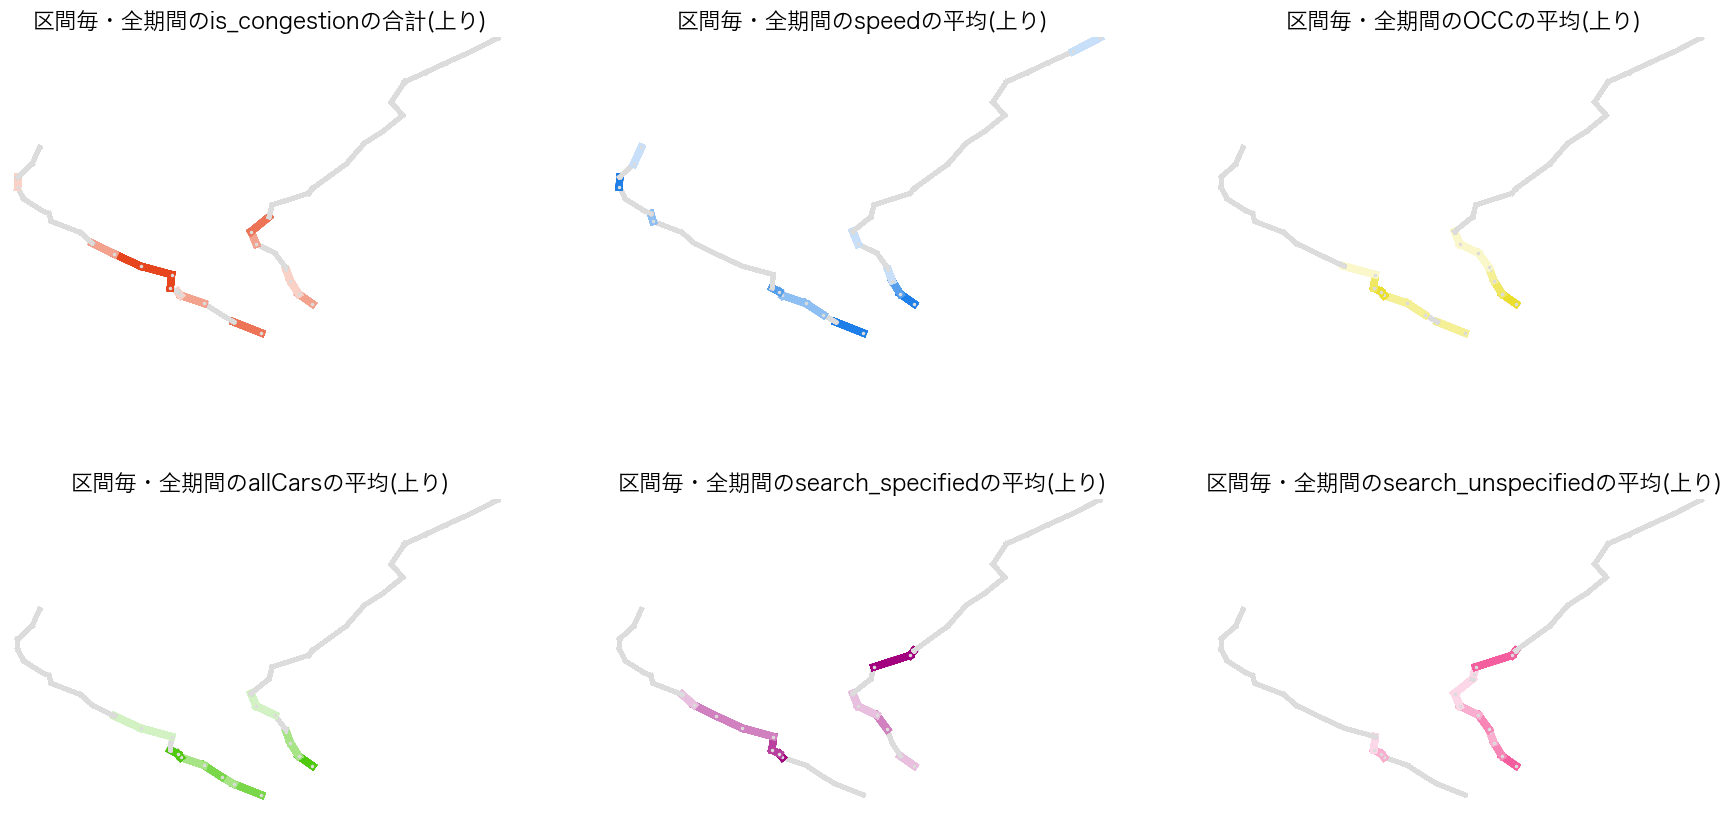

In [115]:
fig = plt.figure(figsize=(22,10))

plt.subplots_adjust(hspace=0.5)

ax1 = fig.add_subplot(231, title='Is congestion', ylim=(35.7, 37.12), xlim=(139, 140.2))
ax2 = fig.add_subplot(232, title='Speed', ylim=(35.7, 37.12), xlim=(139, 140.2))
ax3 = fig.add_subplot(233, title='OCC', ylim=(35.7, 37.12), xlim=(139, 140.2))
ax4 = fig.add_subplot(234, title='allCars', ylim=(35.7, 37.12), xlim=(139, 140.2))
ax5 = fig.add_subplot(235, title='Search specified', ylim=(35.7, 37.12), xlim=(139, 140.2))
ax6 = fig.add_subplot(236, title='Search unspecified', ylim=(35.7, 37.12), xlim=(139, 140.2))

ax1.set_title('区間毎・全期間のis_congestionの合計(上り)', fontsize=16)
ax2.set_title('区間毎・全期間のspeedの平均(上り)', fontsize=16)
ax3.set_title('区間毎・全期間のOCCの平均(上り)', fontsize=16)
ax4.set_title('区間毎・全期間のallCarsの平均(上り)', fontsize=16)
ax5.set_title('区間毎・全期間のsearch_specifiedの平均(上り)', fontsize=16)
ax6.set_title('区間毎・全期間のsearch_unspecifiedの平均(上り)', fontsize=16)

for index,row in block_df_202207_1.iterrows():
    
    start_lng = row['start_lng']
    end_lng = row['end_lng']
    start_lat = row['start_lat']
    end_lat = row['end_lat']
    congestion = row['is_congestion_block_count']
    
    colorlist=['#E7451D', '#ED7456', '#F3A28E', '#F9D1C7', 'gainsboro']

    if congestion >= congestion_series_202207_1[0.95]:
        color = colorlist[0]
        linewidth = 5
    elif (congestion >= congestion_series_202207_1[0.9]) & (congestion < congestion_series_202207_1[0.95]):
        color = colorlist[1]
        linewidth = 5
    elif (congestion >= congestion_series_202207_1[0.8]) & (congestion < congestion_series_202207_1[0.9]):
        color = colorlist[2]
        linewidth = 5
    elif (congestion >= congestion_series_202207_1[0.7]) & (congestion < congestion_series_202207_1[0.8]):
        color = colorlist[3]
        linewidth = 5        
    else:
        color = colorlist[4]
        linewidth = 3
        
    ax1.plot([start_lng, end_lng], [start_lat, end_lat], color=color, linestyle='-', linewidth=linewidth)
    ax1.plot(start_lng, start_lat, marker='.', c='gainsboro', markersize=3) 
    ax1.plot(end_lng, end_lat, marker='.', c='gainsboro',markersize=3)
    ax1.axis('off')


for index,row in block_df_202207_1.iterrows():
    
    start_lng = row['start_lng']
    end_lng = row['end_lng']
    start_lat = row['start_lat']
    end_lat = row['end_lat']
    speed = row['speed_block_mean']
    
    colorlist=['#1D7FE7', '#569FED', '#8EBFF3', '#C7DFF9', 'gainsboro']

    if speed <= speed_series_202207_1[0.05]:
        color = colorlist[0]
        linewidth = 5
    elif (speed > speed_series_202207_1[0.05]) & (speed <= speed_series_202207_1[0.1]):
        color = colorlist[1]
        linewidth = 5
    elif (speed > speed_series_202207_1[0.1]) & (speed <= speed_series_202207_1[0.2]):
        color = colorlist[2]
        linewidth = 5
    elif (speed > speed_series_202207_1[0.2]) & (speed <= speed_series_202207_1[0.3]):
        color = colorlist[3]
        linewidth = 5
    else:
        color = colorlist[4]
        linewidth = 3
        
    ax2.plot([start_lng, end_lng], [start_lat, end_lat], color=color, linestyle='-', linewidth=linewidth)
    ax2.plot(start_lng, start_lat, marker='.', c='gainsboro', markersize=3) 
    ax2.plot(end_lng, end_lat, marker='.', c='gainsboro',markersize=3)
    ax2.axis('off')
    
for index,row in block_df_202207_1.iterrows():
    
    start_lng = row['start_lng']
    end_lng = row['end_lng']
    start_lat = row['start_lat']
    end_lat = row['end_lat']
    OCC = row['OCC_block_mean']
    
    colorlist=['#EBDF2D', '#F0E762', '#F5EF96', '#FAF7CB', 'gainsboro']
    
    if OCC >= OCC_series_202207_1[0.95]:
        color = colorlist[0]
        linewidth = 5
    elif (OCC >= OCC_series_202207_1[0.9]) & (OCC < OCC_series_202207_1[0.95]):
        color = colorlist[1]
        linewidth = 5
    elif (OCC >= OCC_series_202207_1[0.8]) & (OCC < OCC_series_202207_1[0.9]):
        color = colorlist[2]
        linewidth = 5
    elif (OCC >= OCC_series_202207_1[0.7]) & (OCC < OCC_series_202207_1[0.8]):
        color = colorlist[3]
        linewidth = 5        
    else:
        color = colorlist[4]
        linewidth = 3
        
    ax3.plot([start_lng, end_lng], [start_lat, end_lat], color=color, linestyle='-', linewidth=linewidth)
    ax3.plot(start_lng, start_lat, marker='.', c='gainsboro', markersize=3) 
    ax3.plot(end_lng, end_lat, marker='.', c='gainsboro',markersize=3)
    ax3.axis('off')
    
for index,row in block_df_202207_1.iterrows():
    
    start_lng = row['start_lng']
    end_lng = row['end_lng']
    start_lat = row['start_lat']
    end_lat = row['end_lat']
    allCars = row['allCars_block_mean']
    
    colorlist=['#4FC90D', '#7BD74A', '#A7E486', '#D3F2C3', 'gainsboro']

    if allCars >= allCars_series_202207_1[0.95]:
        color = colorlist[0]
        linewidth = 5
    elif (allCars >= allCars_series_202207_1[0.9]) & (allCars < allCars_series_202207_1[0.95]):
        color = colorlist[1]
        linewidth = 5
    elif (allCars >= allCars_series_202207_1[0.8]) & (allCars < allCars_series_202207_1[0.9]):
        color = colorlist[2]
        linewidth = 5
    elif (allCars >= allCars_series_202207_1[0.7]) & (allCars < allCars_series_202207_1[0.8]):
        color = colorlist[3]
        linewidth = 5        
    else:
        color = colorlist[4]
        linewidth = 3
        
    ax4.plot([start_lng, end_lng], [start_lat, end_lat], color=color, linestyle='-', linewidth=linewidth)
    ax4.plot(start_lng, start_lat, marker='.', c='gainsboro', markersize=3) 
    ax4.plot(end_lng, end_lat, marker='.', c='gainsboro',markersize=3)
    ax4.axis('off')
    
for index,row in block_df_202207_1.iterrows():
    
    start_lng = row['start_lng']
    end_lng = row['end_lng']
    start_lat = row['start_lat']
    end_lat = row['end_lat']
    search_specified = row['search_specified_block_mean']
    
    colorlist=['#A30080', '#BA40A0', '#D180C0', '#E8BFDF', 'gainsboro']

    if search_specified >= search_specified_series_202207_1[0.95]:
        color = colorlist[0]
        linewidth = 5
    elif (search_specified >= search_specified_series_202207_1[0.9]) & (search_specified < search_specified_series_202207_1[0.95]):
        color = colorlist[1]
        linewidth = 5
    elif (search_specified >= search_specified_series_202207_1[0.8]) & (search_specified < search_specified_series_202207_1[0.9]):
        color = colorlist[2]
        linewidth = 5
    elif (search_specified >= search_specified_series_202207_1[0.7]) & (search_specified < search_specified_series_202207_1[0.8]):
        color = colorlist[3]
        linewidth = 5
    else:
        color = colorlist[4]
        linewidth = 3
        
    ax5.plot([start_lng, end_lng], [start_lat, end_lat], color=color, linestyle='-', linewidth=linewidth)
    ax5.plot(start_lng, start_lat, marker='.', c='gainsboro', markersize=3) 
    ax5.plot(end_lng, end_lat, marker='.', c='gainsboro',markersize=3)
    ax5.axis('off')
    
for index,row in block_df_202207_1.iterrows():
    
    start_lng = row['start_lng']
    end_lng = row['end_lng']
    start_lat = row['start_lat']
    end_lat = row['end_lat']
    search_unspecified = row['search_unspecified_block_mean']
    
    colorlist=['#F45D9E', '#F786B6', '#FAAECF', '#FCD7E7', 'gainsboro']
    
    if search_unspecified >= search_unspecified_series_202207_1[0.95]:
        color = colorlist[0]
        linewidth = 5
    elif (search_unspecified >= search_unspecified_series_202207_1[0.9]) & (search_unspecified < search_unspecified_series_202207_1[0.95]):
        color = colorlist[1]
        linewidth = 5
    elif (search_unspecified >= search_unspecified_series_202207_1[0.8]) & (search_unspecified < search_unspecified_series_202207_1[0.9]):
        color = colorlist[2]
        linewidth = 5
    elif (search_unspecified >= search_unspecified_series_202207_1[0.7]) & (search_unspecified < search_unspecified_series_202207_1[0.8]):
        color = colorlist[3]
        linewidth = 5
    else:
        color = colorlist[4]
        linewidth = 3
        
    ax6.plot([start_lng, end_lng], [start_lat, end_lat], color=color, linestyle='-', linewidth=linewidth)
    ax6.plot(start_lng, start_lat, marker='.', c='gainsboro', markersize=3) 
    ax6.plot(end_lng, end_lat, marker='.', c='gainsboro',markersize=3) 
    ax6.axis('off')


In [100]:
congestion_series_202207_0 = block_df_202207_0['is_congestion_block_count'].quantile([0.95, 0.9, 0.8, 0.7])
speed_series_202207_0 = block_df_202207_0['speed_block_mean'].quantile([0.05, 0.1, 0.2, 0.3])
search_specified_series_202207_0 = block_df_202207_0['search_specified_block_mean'].quantile([0.95, 0.9, 0.8, 0.7])
search_unspecified_series_202207_0 = block_df_202207_0['search_unspecified_block_mean'].quantile([0.95, 0.9, 0.8, 0.7])
OCC_series_202207_0 = block_df_202207_0['OCC_block_mean'].quantile([0.95, 0.9, 0.8, 0.7])
allCars_series_202207_0 = block_df_202207_0['allCars_block_mean'].quantile([0.95, 0.9, 0.8, 0.7])

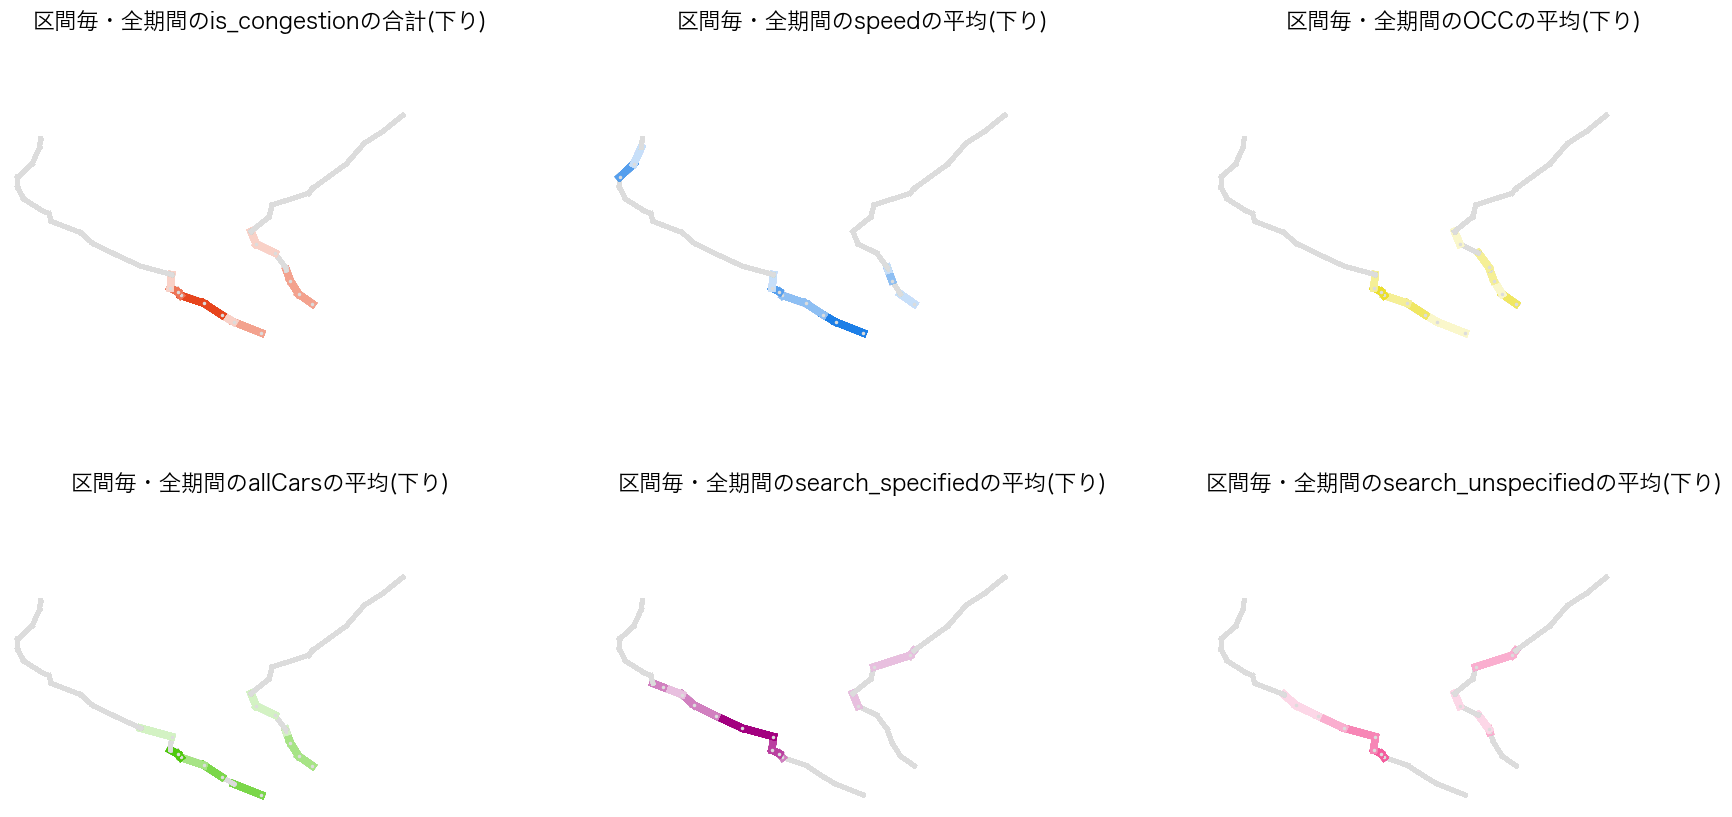

In [123]:
fig = plt.figure(figsize=(22,10))

plt.subplots_adjust(hspace=0.5)

ax1 = fig.add_subplot(231, title='Is congestion', ylim=(35.7, 37.12), xlim=(139, 140.2))
ax2 = fig.add_subplot(232, title='Speed', ylim=(35.7, 37.12), xlim=(139, 140.2))
ax3 = fig.add_subplot(233, title='OCC', ylim=(35.7, 37.12), xlim=(139, 140.2))
ax4 = fig.add_subplot(234, title='allCars', ylim=(35.7, 37.12), xlim=(139, 140.2))
ax5 = fig.add_subplot(235, title='Search specified', ylim=(35.7, 37.12), xlim=(139, 140.2))
ax6 = fig.add_subplot(236, title='Search unspecified', ylim=(35.7, 37.12), xlim=(139, 140.2))

ax1.set_title('区間毎・全期間のis_congestionの合計(下り)', fontsize=16)
ax2.set_title('区間毎・全期間のspeedの平均(下り)', fontsize=16)
ax3.set_title('区間毎・全期間のOCCの平均(下り)', fontsize=16)
ax4.set_title('区間毎・全期間のallCarsの平均(下り)', fontsize=16)
ax5.set_title('区間毎・全期間のsearch_specifiedの平均(下り)', fontsize=16)
ax6.set_title('区間毎・全期間のsearch_unspecifiedの平均(下り)', fontsize=16)

for index,row in block_df_202207_0.iterrows():
    
    start_lng = row['start_lng']
    end_lng = row['end_lng']
    start_lat = row['start_lat']
    end_lat = row['end_lat']
    congestion = row['is_congestion_block_count']
    
    colorlist=['#E7451D', '#ED7456', '#F3A28E', '#F9D1C7', 'gainsboro']

    if congestion >= congestion_series_202207_0[0.95]:
        color = colorlist[0]
        linewidth = 5
    elif (congestion >= congestion_series_202207_0[0.9]) & (congestion < congestion_series_202207_0[0.95]):
        color = colorlist[1]
        linewidth = 5
    elif (congestion >= congestion_series_202207_0[0.8]) & (congestion < congestion_series_202207_0[0.9]):
        color = colorlist[2]
        linewidth = 5
    elif (congestion >= congestion_series_202207_0[0.7]) & (congestion < congestion_series_202207_0[0.8]):
        color = colorlist[3]
        linewidth = 5        
    else:
        color = colorlist[4]
        linewidth = 3
        
    ax1.plot([start_lng, end_lng], [start_lat, end_lat], color=color, linestyle='-', linewidth=linewidth)
    ax1.plot(start_lng, start_lat, marker='.', c='gainsboro', markersize=3) 
    ax1.plot(end_lng, end_lat, marker='.', c='gainsboro',markersize=3)
    ax1.axis('off')
    
for index,row in block_df_202207_0.iterrows():
    
    start_lng = row['start_lng']
    end_lng = row['end_lng']
    start_lat = row['start_lat']
    end_lat = row['end_lat']
    speed = row['speed_block_mean']
    
    colorlist=['#1D7FE7', '#569FED', '#8EBFF3', '#C7DFF9', 'gainsboro']

    if speed <= speed_series_202207_0[0.05]:
        color = colorlist[0]
        linewidth = 5
    elif (speed > speed_series_202207_0[0.05]) & (speed <= speed_series_202207_0[0.1]):
        color = colorlist[1]
        linewidth = 5
    elif (speed > speed_series_202207_0[0.1]) & (speed <= speed_series_202207_0[0.2]):
        color = colorlist[2]
        linewidth = 5
    elif (speed > speed_series_202207_0[0.2]) & (speed <= speed_series_202207_0[0.3]):
        color = colorlist[3]
        linewidth = 5
    else:
        color = colorlist[4]
        linewidth = 3
        
    ax2.plot([start_lng, end_lng], [start_lat, end_lat], color=color, linestyle='-', linewidth=linewidth)
    ax2.plot(start_lng, start_lat, marker='.', c='gainsboro', markersize=3) 
    ax2.plot(end_lng, end_lat, marker='.', c='gainsboro',markersize=3)
    ax2.axis('off')
    
for index,row in block_df_202207_0.iterrows():
    
    start_lng = row['start_lng']
    end_lng = row['end_lng']
    start_lat = row['start_lat']
    end_lat = row['end_lat']
    OCC = row['OCC_block_mean']
    
    colorlist=['#EBDF2D', '#F0E762', '#F5EF96', '#FAF7CB', 'gainsboro']
    
    if OCC >= OCC_series_202207_0[0.95]:
        color = colorlist[0]
        linewidth = 5
    elif (OCC >= OCC_series_202207_0[0.9]) & (OCC < OCC_series_202207_0[0.95]):
        color = colorlist[1]
        linewidth = 5
    elif (OCC >= OCC_series_202207_0[0.8]) & (OCC < OCC_series_202207_0[0.9]):
        color = colorlist[2]
        linewidth = 5
    elif (OCC >= OCC_series_202207_0[0.7]) & (OCC < OCC_series_202207_0[0.8]):
        color = colorlist[3]
        linewidth = 5        
    else:
        color = colorlist[4]
        linewidth = 3
        
    ax3.plot([start_lng, end_lng], [start_lat, end_lat], color=color, linestyle='-', linewidth=linewidth)
    ax3.plot(start_lng, start_lat, marker='.', c='gainsboro', markersize=3) 
    ax3.plot(end_lng, end_lat, marker='.', c='gainsboro',markersize=3)
    ax3.axis('off')
    
for index,row in block_df_202207_0.iterrows():
    
    start_lng = row['start_lng']
    end_lng = row['end_lng']
    start_lat = row['start_lat']
    end_lat = row['end_lat']
    allCars = row['allCars_block_mean']
    
    colorlist=['#4FC90D', '#7BD74A', '#A7E486', '#D3F2C3', 'gainsboro']

    if allCars >= allCars_series_202207_0[0.95]:
        color = colorlist[0]
        linewidth = 5
    elif (allCars >= allCars_series_202207_0[0.9]) & (allCars < allCars_series_202207_0[0.95]):
        color = colorlist[1]
        linewidth = 5
    elif (allCars >= allCars_series_202207_0[0.8]) & (allCars < allCars_series_202207_0[0.9]):
        color = colorlist[2]
        linewidth = 5
    elif (allCars >= allCars_series_202207_0[0.7]) & (allCars < allCars_series_202207_0[0.8]):
        color = colorlist[3]
        linewidth = 5        
    else:
        color = colorlist[4]
        linewidth = 3
        
    ax4.plot([start_lng, end_lng], [start_lat, end_lat], color=color, linestyle='-', linewidth=linewidth)
    ax4.plot(start_lng, start_lat, marker='.', c='gainsboro', markersize=3) 
    ax4.plot(end_lng, end_lat, marker='.', c='gainsboro',markersize=3)
    ax4.axis('off')
    
for index,row in block_df_202207_0.iterrows():
    
    start_lng = row['start_lng']
    end_lng = row['end_lng']
    start_lat = row['start_lat']
    end_lat = row['end_lat']
    search_specified = row['search_specified_block_mean']
    
    colorlist=['#A30080', '#BA40A0', '#D180C0', '#E8BFDF', 'gainsboro']

    if search_specified >= search_specified_series_202207_0[0.95]:
        color = colorlist[0]
        linewidth = 5
    elif (search_specified >= search_specified_series_202207_0[0.9]) & (search_specified < search_specified_series_202207_0[0.95]):
        color = colorlist[1]
        linewidth = 5
    elif (search_specified >= search_specified_series_202207_0[0.8]) & (search_specified < search_specified_series_202207_0[0.9]):
        color = colorlist[2]
        linewidth = 5
    elif (search_specified >= search_specified_series_202207_0[0.7]) & (search_specified < search_specified_series_202207_0[0.8]):
        color = colorlist[3]
        linewidth = 5
    else:
        color = colorlist[4]
        linewidth = 3
        
    ax5.plot([start_lng, end_lng], [start_lat, end_lat], color=color, linestyle='-', linewidth=linewidth)
    ax5.plot(start_lng, start_lat, marker='.', c='gainsboro', markersize=3) 
    ax5.plot(end_lng, end_lat, marker='.', c='gainsboro',markersize=3)
    ax5.axis('off')
    
for index,row in block_df_202207_0.iterrows():
    
    start_lng = row['start_lng']
    end_lng = row['end_lng']
    start_lat = row['start_lat']
    end_lat = row['end_lat']
    search_unspecified = row['search_unspecified_block_mean']
    
    colorlist=['#F45D9E', '#F786B6', '#FAAECF', '#FCD7E7', 'gainsboro']
    
    if search_unspecified >= search_unspecified_series_202207_0[0.95]:
        color = colorlist[0]
        linewidth = 5
    elif (search_unspecified >= search_unspecified_series_202207_0[0.9]) & (search_unspecified < search_unspecified_series_202207_0[0.95]):
        color = colorlist[1]
        linewidth = 5
    elif (search_unspecified >= search_unspecified_series_202207_0[0.8]) & (search_unspecified < search_unspecified_series_202207_0[0.9]):
        color = colorlist[2]
        linewidth = 5
    elif (search_unspecified >= search_unspecified_series_202207_0[0.7]) & (search_unspecified < search_unspecified_series_202207_0[0.8]):
        color = colorlist[3]
        linewidth = 5
    else:
        color = colorlist[4]
        linewidth = 3
        
    ax6.plot([start_lng, end_lng], [start_lat, end_lat], color=color, linestyle='-', linewidth=linewidth)
    ax6.plot(start_lng, start_lat, marker='.', c='gainsboro', markersize=3) 
    ax6.plot(end_lng, end_lat, marker='.', c='gainsboro',markersize=3) 
    ax6.axis('off')
